### Plots comparing the old (Nancy's) and new (https://wiki.icecube.wisc.edu/index.php/Simulation_and_Datasets_Used) simulations

Also some approximate sensitivity plots at the end

In [1]:
import numpy as np
import pandas as pd
import nuflux
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16

In [3]:
NOMINAL_PHI = 2.12
NOMINAL_GAMMA = 2.87
# NOMINAL_PHI = 2.04
# NOMINAL_GAMMA = 2.62
LIVETIME = 305684668.46

In [4]:
sig_NET1 = 0.99
sig_NET2 = 0.98
sig_NET3 = 0.85

net3_val = 0.95
qasym_val = 0.05
outer_nums = np.array([75, 76, 77, 78, 72, 73, 74, 67, 59, 50, 40, 30, 21, 
                       13, 6, 5, 4, 3, 2, 1, 7, 14, 22, 31, 41, 51, 60, 68])

In [5]:
new_df = pd.read_hdf('nominal_new_sim_09_29_2021.h5', 'df')
old_df = pd.read_hdf('nominal_09_17_2021.h5', 'df')

In [6]:
def weight_astro(astro_d, phi=NOMINAL_PHI, gamma=NOMINAL_GAMMA):
    en_weights = 1e-18 * phi * (astro_d.energy / 1e5)**(-gamma)
    return en_weights * astro_d.oneweight / astro_d.n_files / astro_d.n_events


def weight_atmos(atmos_d, flux):
    flux_weight = flux(atmos_d.pid.astype(np.int32), 
                       atmos_d.energy, 
                       atmos_d.coszen)
    
    denom = atmos_d.n_files * atmos_d.n_events * atmos_d.typeweight
    return flux_weight * atmos_d.oneweight / denom

In [7]:
conv_model = nuflux.makeFlux('honda2006')
# conv_model.knee_reweighting_model = "gaisserH3a_elbert"
conv_flux = conv_model.getFlux
# conv_flux = nuflux.makeFlux('H3a_SIBYLL23C_conv').getFlux 
def conv_weight(d):
    return weight_atmos(d, conv_flux)

prompt_flux = nuflux.makeFlux('H3a_SIBYLL23C_pr').getFlux
# prompt_flux = nuflux.makeFlux('BERSS_H3p_central').getFlux
def prompt_weight(d):
    return weight_atmos(d, prompt_flux)

def total_weight(d):
    return weight_astro(d) + prompt_weight(d) + conv_weight(d)

def bg_weight(d):
    base_weights = total_weight(d)
    sig_mask = (d.it == 1) & (np.abs(np.abs(d.pid)) == 16)
    base_weights[sig_mask] -= weight_astro(d[sig_mask])
    
    return base_weights

In [8]:
def apply_sig_cuts(d, qasym_cut=qasym_val):
    mask = (d.n1 > sig_NET1) & (d.n2 > sig_NET2) & (d.n3 > sig_NET3)
        
    mask &= (~np.isin(d.stnum0, outer_nums)) | ((d.n3 > net3_val) & (d.q_asym > qasym_cut))
    
    return d[mask]

### Look at prompt flavor composition

In [9]:
test = apply_sig_cuts(new_df[new_df.pid != 0]).copy()
test['total_weight'] = prompt_weight(test) * LIVETIME
test.groupby('pid').sum()['total_weight']

pid
-16.0    0.043832
-14.0    0.005238
-12.0    0.002454
 12.0    0.001282
 14.0    0.006833
 16.0    0.049237
Name: total_weight, dtype: float64

In [10]:
(0.043832 + 0.049237) / test.groupby('pid').sum()['total_weight'].sum()

0.8548208600688214

In [11]:
def make_en_plot(old_d, new_d, title, include_old, ax=None, weight_func=weight_astro, livetime=LIVETIME):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))

    en_bins = np.logspace(0, 5, 61)

    if include_old:
        ds = (old_d, new_d)
        prefixes = ('old', 'new')
        suffixes = ('', ', signal cuts')
    else:
        ds = (new_d,)
        prefixes = ('',)
        suffixes = ('preliminary cuts', 'signal cuts')
    
    for base_d, leg_label in zip(ds, prefixes):
        for d, label_suffix in zip((base_d, apply_sig_cuts(base_d)), suffixes):
            try:
                rate = d.weight
            except AttributeError:
                rate = weight_func(d)
    
            hist = np.histogram(d.energy / 1e3, bins=en_bins, weights=rate)[0]
            errors = np.histogram(d.energy / 1e3, bins=en_bins, weights=(rate**2))[0]
            
            total = rate.sum() * livetime
            total_err = np.sqrt((rate**2).sum()) * livetime
            label = f"{leg_label}{label_suffix}: ${total:.2f} \pm {total_err:.2f}$"

            l = ax.step(en_bins, np.hstack((hist, [0])), label=label, where='post')
            ax.errorbar(0.5*(en_bins[1:] + en_bins[:-1]), hist, xerr=None, 
                        yerr=np.sqrt(errors), fmt='o', markersize=0,
                        color = l[0].get_color())


    ax.legend(loc='upper right', fontsize=18)
    ax.set_xlabel(r'$E_\nu$ / TeV')
    ax.set_ylabel('rate / Hz')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(title)
    
    ax.set_ylim(1e-12, 1e-6)

    return ax

In [12]:
def make_czen_plot(old_d, new_d, title, include_old=False, ax=None, weight_func=weight_astro, livetime=LIVETIME):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))

    czen_bins = np.linspace(-1, 1, 61)
    
    if include_old:
        ds = (old_d, new_d)
        prefixes = ('old', 'new')
        suffixes = ('', ', signal cuts')
    else:
        ds = (new_d,)
        prefixes = ('',)
        suffixes = ('preliminary cuts', 'signal cuts')
    
    for base_d, leg_label in zip(ds, prefixes):
        for d, label_suffix in zip((base_d, apply_sig_cuts(base_d)), suffixes):
            try:
                rate = d.weight
            except AttributeError:
                rate = weight_func(d)
            
            hist = np.histogram(d.coszen, bins=czen_bins, weights=rate)[0]
            errors = np.histogram(d.coszen, bins=czen_bins, weights=(rate**2))[0]
            
            total = rate.sum() * livetime
            total_err = np.sqrt((rate**2).sum()) * livetime
            label = f"{leg_label}{label_suffix}: ${total:.2f} \pm {total_err:.2f}$"

            l = ax.step(czen_bins, np.hstack((hist, [0])), label=label, where='post')
            ax.errorbar(0.5*(czen_bins[1:] + czen_bins[:-1]), hist, xerr=None, 
                        yerr=np.sqrt(errors), fmt='o', markersize=0,
                        color = l[0].get_color())


    ax.legend(loc='upper right', fontsize=18)
    ax.set_xlabel(r'$\cos (\mathrm{zen})$')
    ax.set_ylabel('rate / Hz')
    ax.set_title(title)
    ax.set_yscale('log')
    
    ax.set_ylim(1e-11, 1e-6)
    ax.set_xlim(-1, 1)
    
    return ax

In [13]:
def plot_by_componenet(plotter, include_old=False):
    fig, axes = plt.subplots(figsize=(48, 16), nrows=2, ncols=4)
    axiter = axes.flat
    
    ax = next(axiter)
    old_nu = old_df[old_df.label != 7]
    new_nu = new_df[new_df.pid != 0]
    ax = plotter(old_nu, new_nu, r'total neutrino expectation', include_old,
                 weight_func=total_weight, ax=ax)

    ax = next(axiter)
    tau_CC_old = old_df[old_df.label == 0]
    tau_CC_new = new_df[(new_df.it == 1) & (np.abs(new_df.pid) == 16)]
    ax = plotter(tau_CC_old, tau_CC_new, r'astrophysical $\nu_\tau$ CC', 
                 include_old, ax=ax)
    
    ax = next(axiter)
    old_bg = old_df[(old_df.label != 0) & (old_df.label != 7)]
    ax = plotter(old_bg, new_nu, r'total background expectation', 
                 include_old, weight_func=bg_weight, ax=ax)

    ax = next(axiter)
    mu_CC_old = old_df[old_df.label == 1]
    mu_CC_new = new_df[(new_df.it == 1) & (np.abs(new_df.pid) == 14)]
    ax = plotter(mu_CC_old, mu_CC_new, r'astrophysical $\nu_\mu$ CC', 
                 include_old, ax=ax)

    ax = next(axiter)
    e_CC_old = old_df[(old_df.label == 2) | (old_df.label == 3)]
    e_CC_new = new_df[((new_df.it == 1) | (new_df.it == 3)) & (np.abs(new_df.pid) == 12)]
    ax = plotter(e_CC_old, e_CC_new, r'astrophysical $\nu_e$ CC', 
                 include_old, ax=ax)

    ax = next(axiter)
    NC_old = old_df[old_df.label == 4]
    NC_new = new_df[new_df.it == 2]
    ax = plotter(NC_old, NC_new, r'astrophysical $\nu$ NC', 
                 include_old, ax=ax)

    ax = next(axiter)
    atmos_conv_old = old_df[old_df.label == 5]
    atmos_new = new_df[new_df.it != 0]
    ax = plotter(atmos_conv_old, atmos_new, 
                 r'total conventional atmopsheric',
                 include_old,
                 weight_func=conv_weight, ax=ax)

    ax = next(axiter)
    atmos_prompt_old = old_df[old_df.label == 6]
    ax = plotter(atmos_prompt_old, atmos_new, 
                 r'total prompt atmospheric',
                 include_old,
                 weight_func=prompt_weight,
                 ax=ax)
    
    return fig

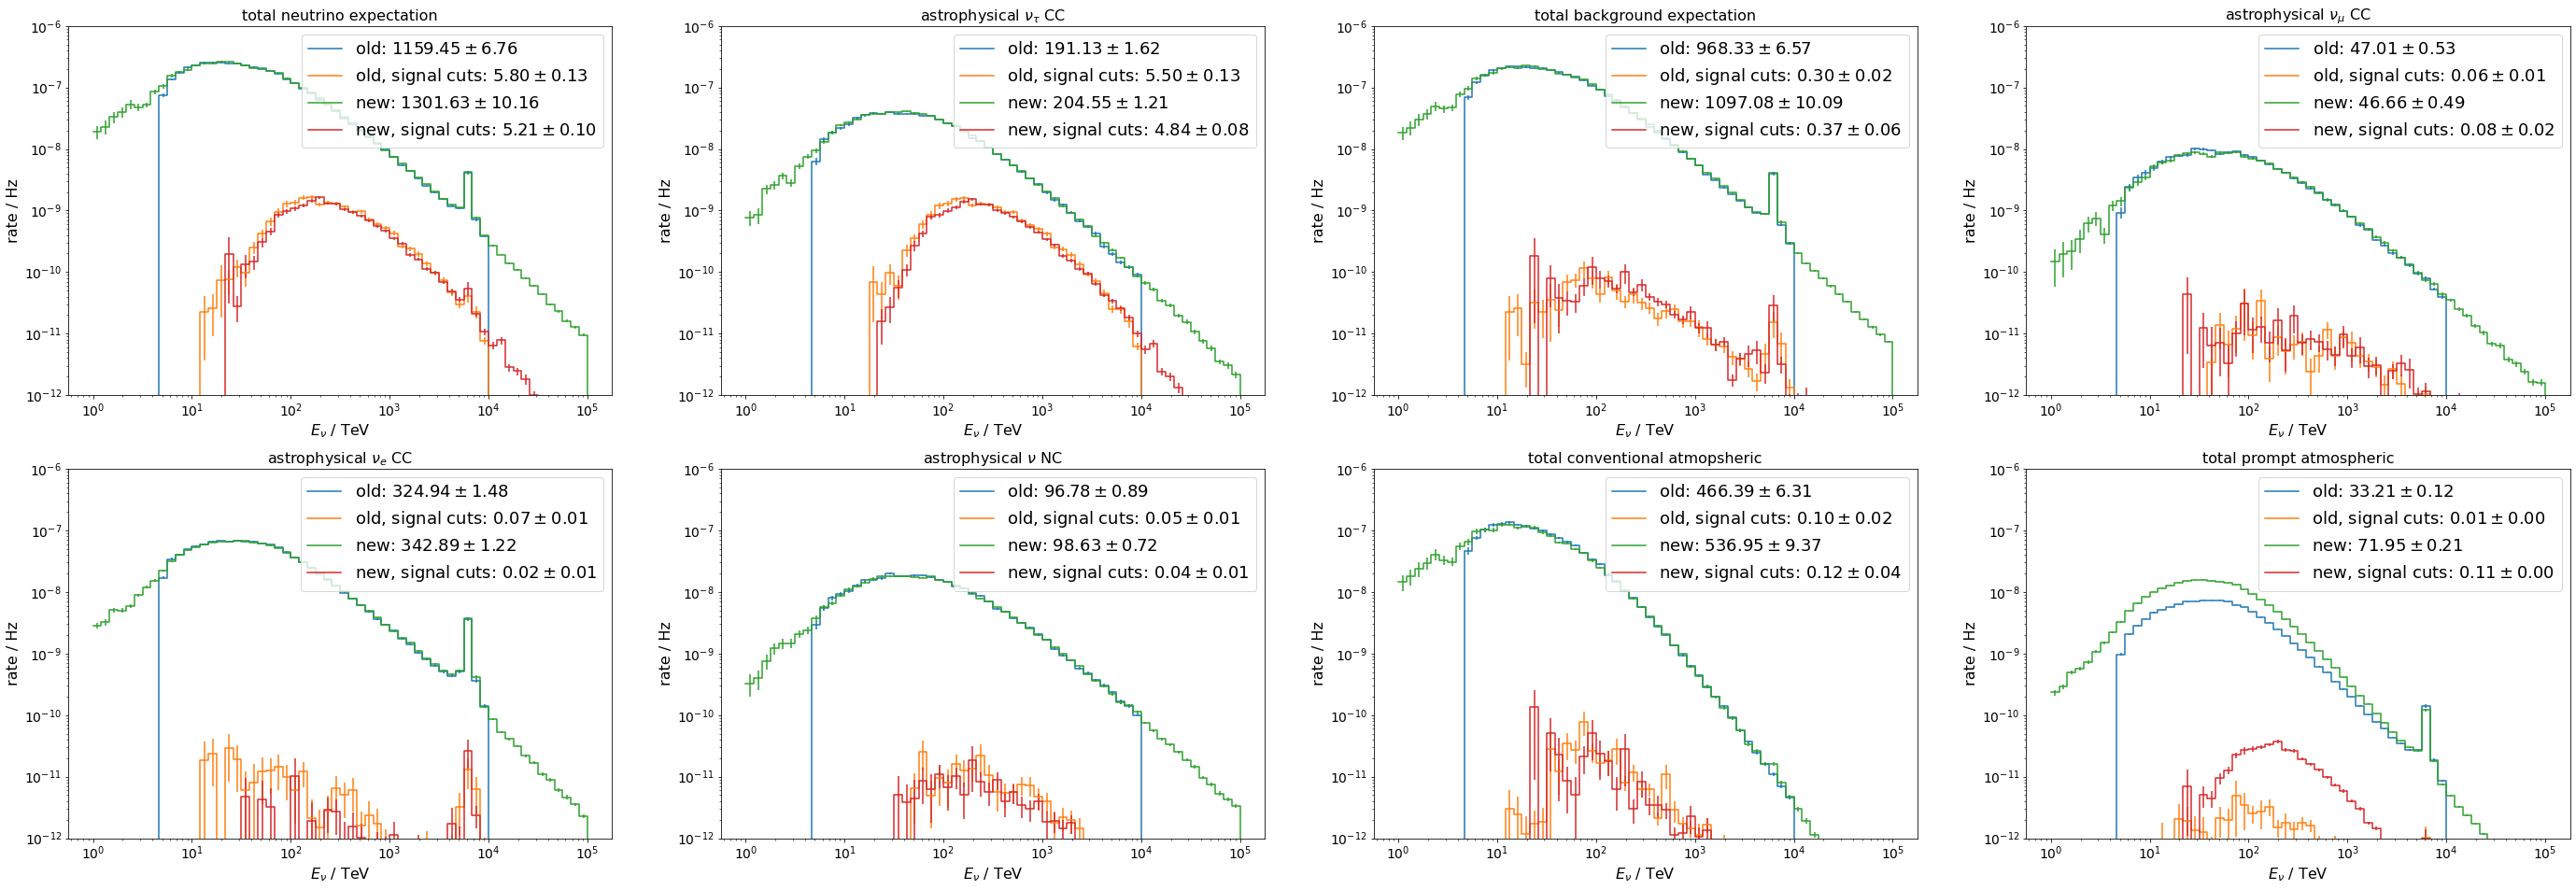

In [14]:
fig = plot_by_componenet(make_en_plot, include_old=True)
fig.savefig('old_vs_new.pdf', bbox_inches='tight')
fig.savefig('old_vs_new_energy.png', bbox_inches='tight')

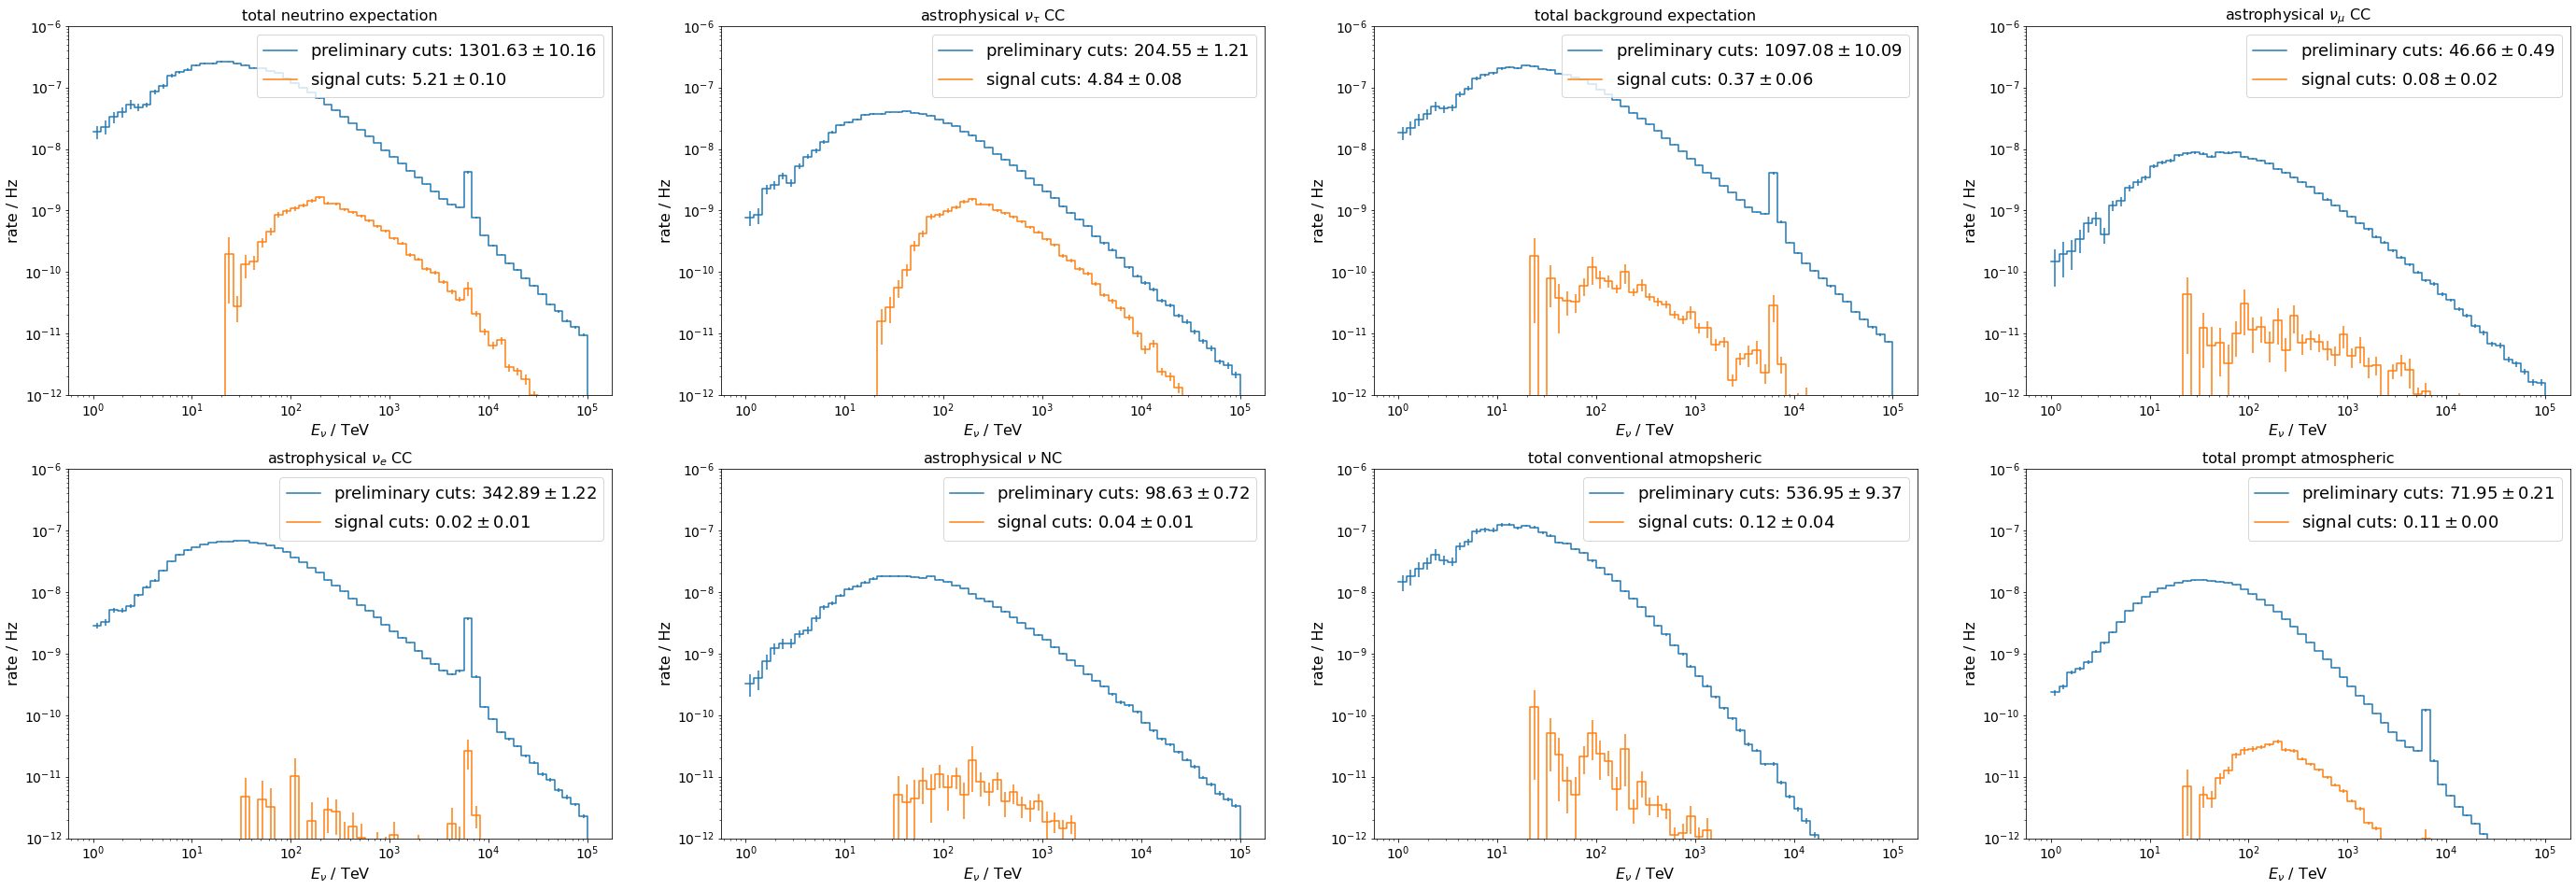

In [15]:
fig = plot_by_componenet(make_en_plot, include_old=False)
fig.savefig('expectation_vs_E_by_component.png', bbox_inches='tight')

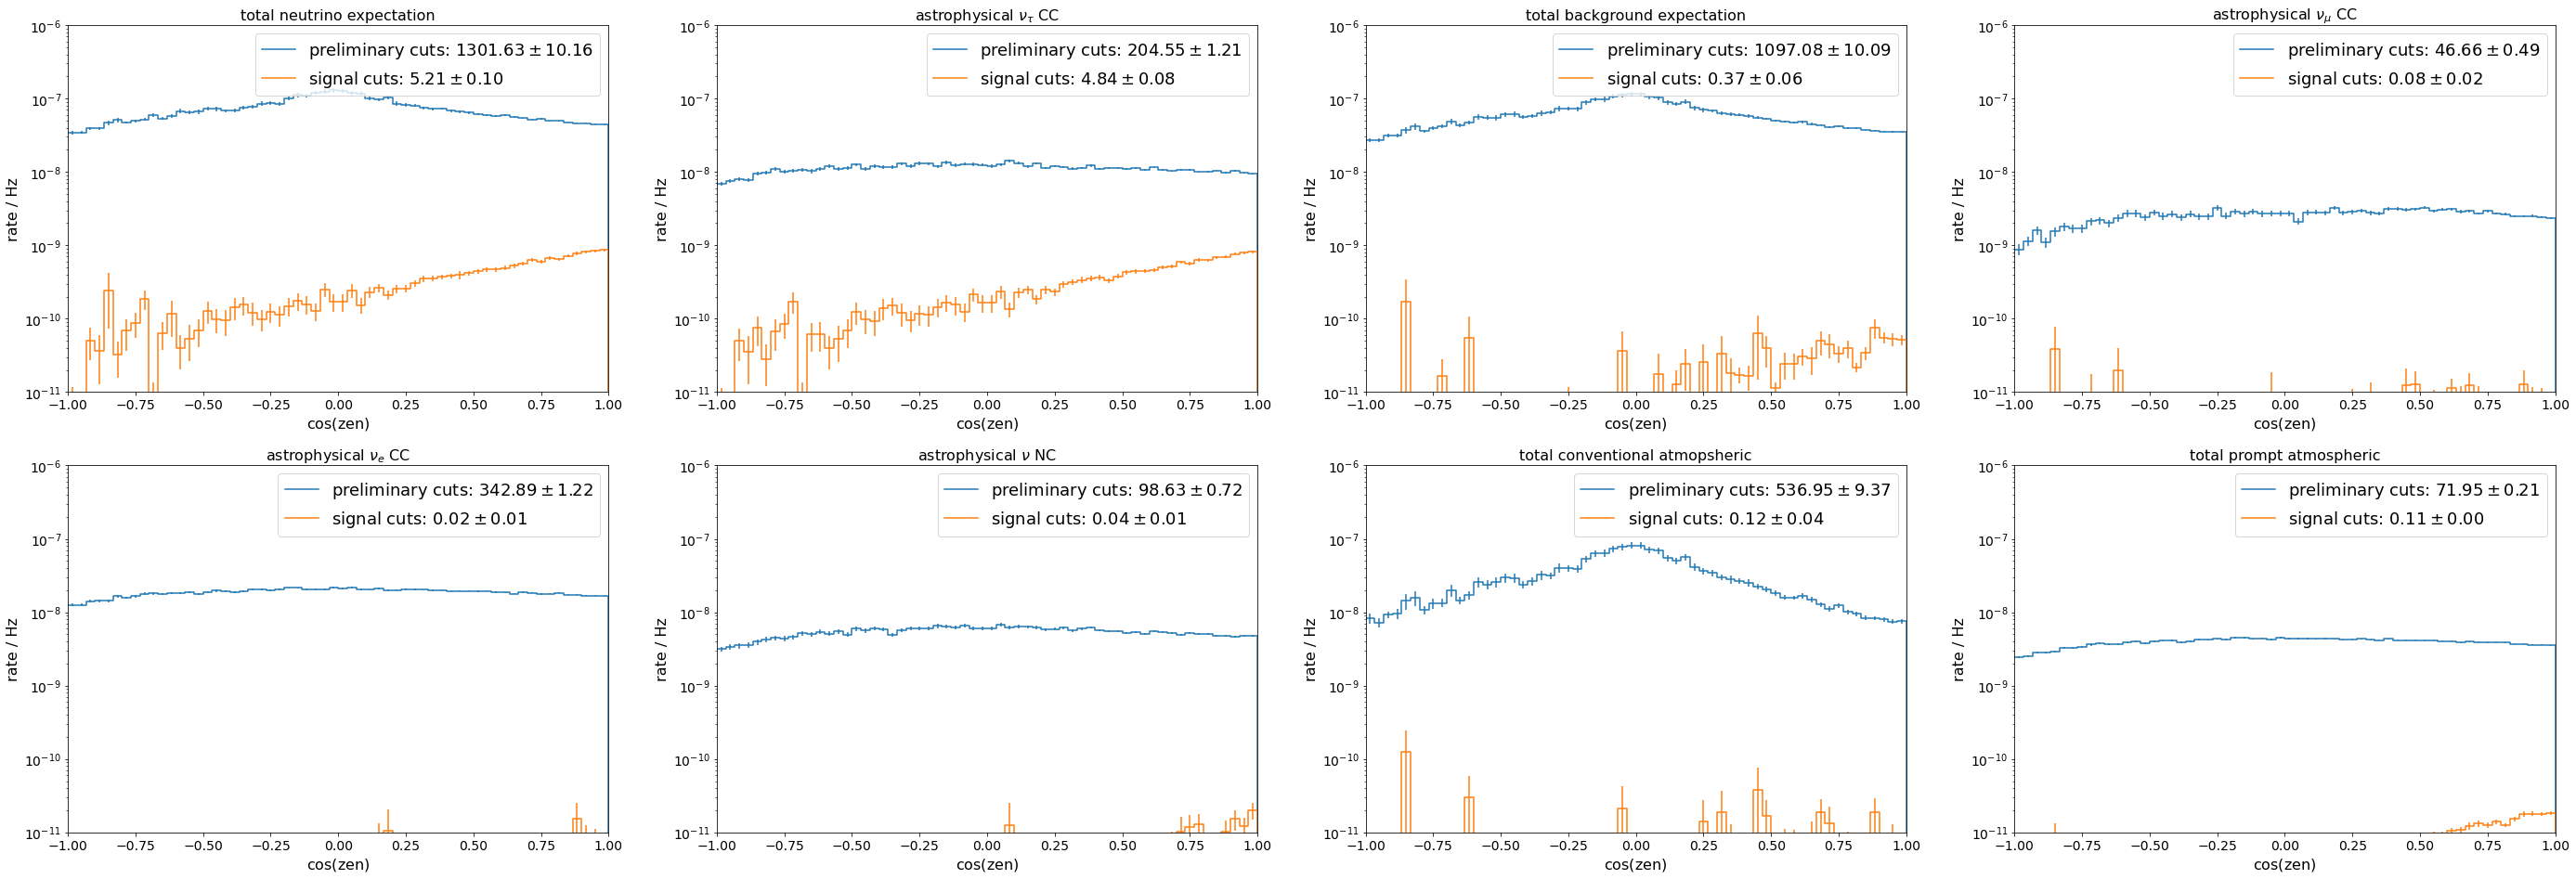

In [16]:
fig = plot_by_componenet(make_czen_plot)
fig.savefig('expectation_vs_coszen_by_component.pdf', bbox_inches='tight')
fig.savefig('expectation_vs_coszen_by_component.png', bbox_inches='tight')

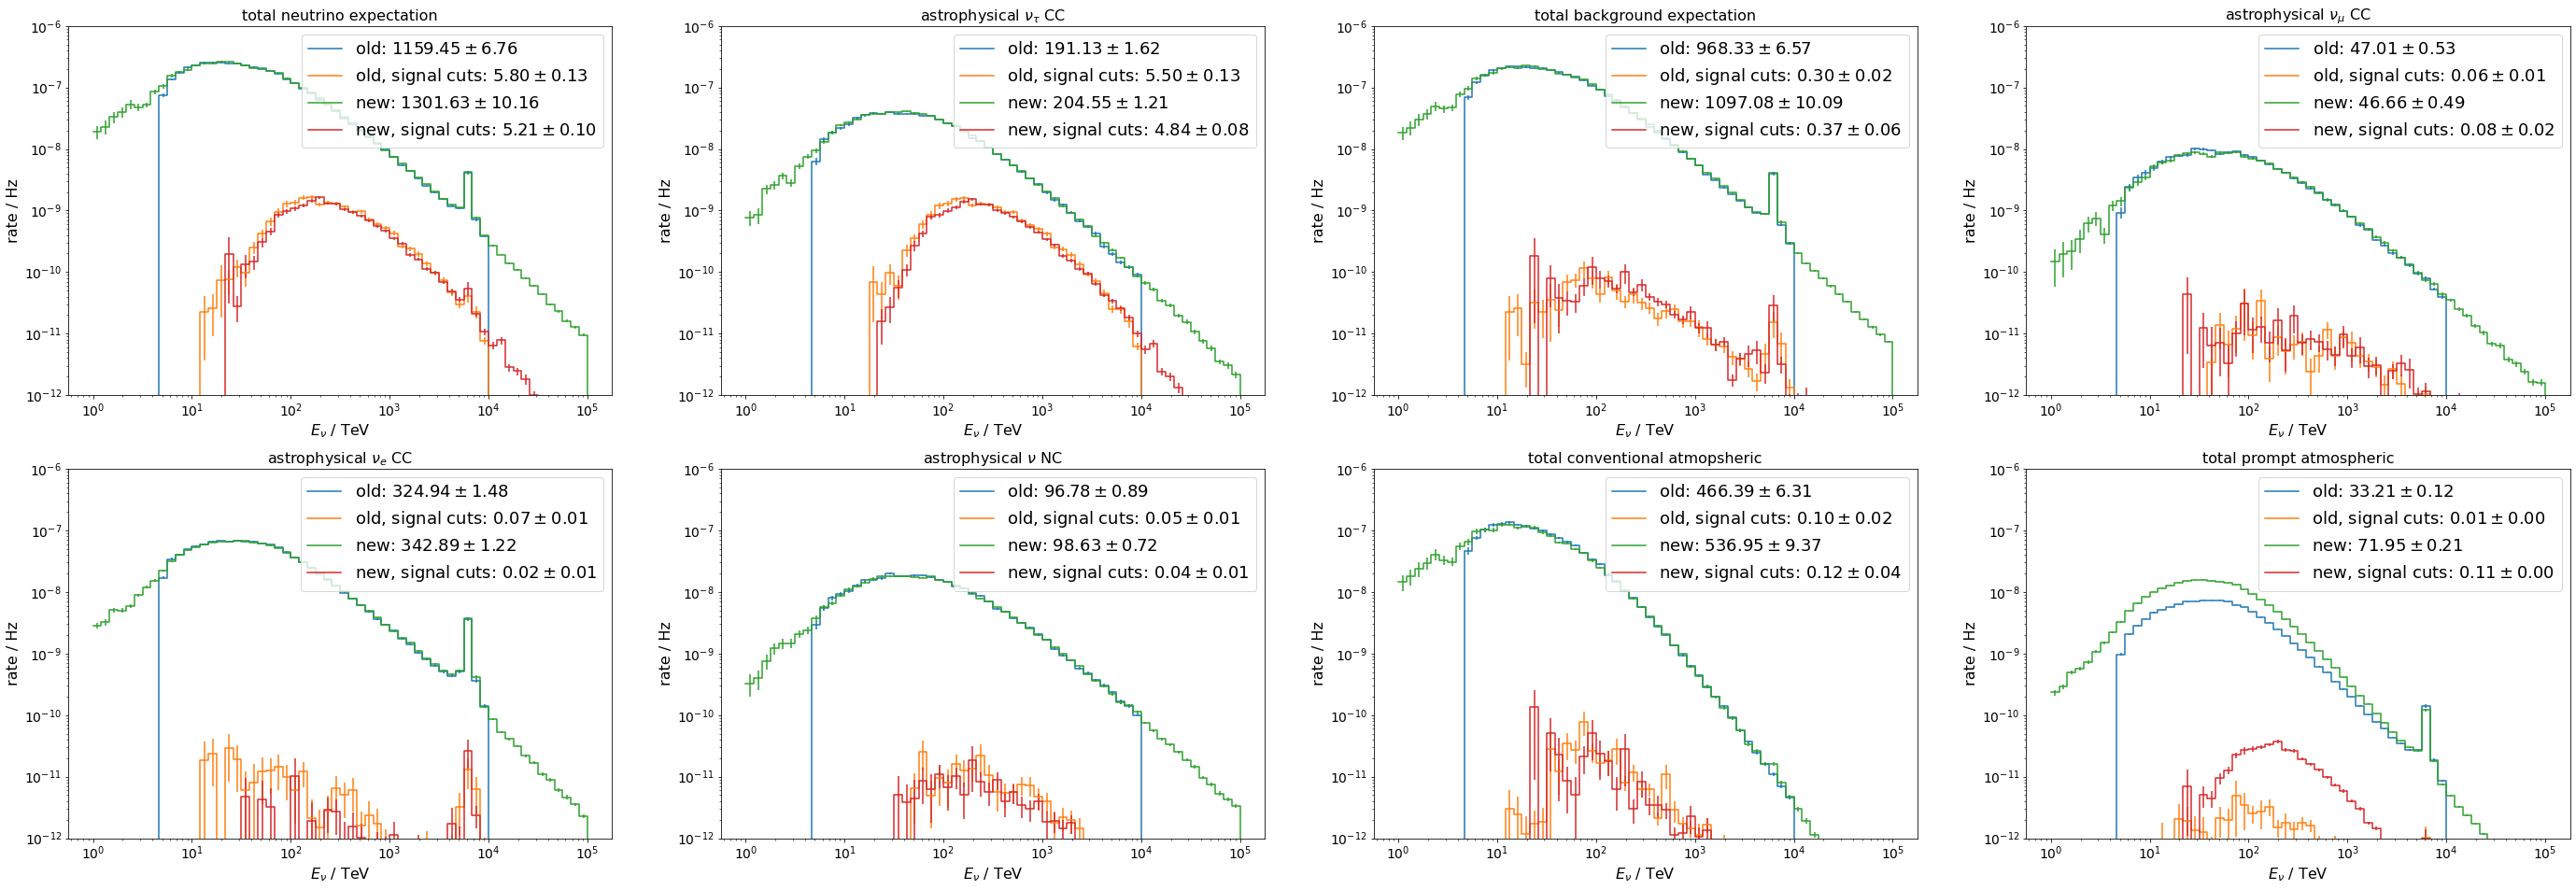

In [17]:
fig = plot_by_componenet(make_en_plot, include_old=True)

# Expected charge asymmetry for signal events

In [18]:
sig_df = apply_sig_cuts(new_df[(np.abs(new_df.pid) == 16) & (new_df.it == 1)], 0.00)
weight_astro(sig_df).sum()*LIVETIME

4.967465312111386

In [19]:
sig_df = apply_sig_cuts(new_df[(np.abs(new_df.pid) == 16) & (new_df.it == 1)], 0.05)
weight_astro(sig_df).sum()*LIVETIME

4.837046639718256

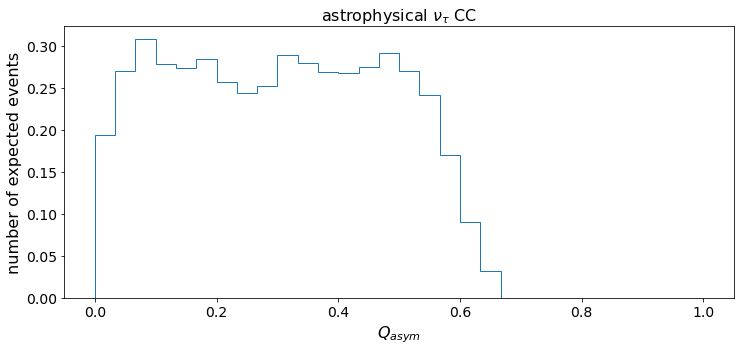

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))

sig_df = apply_sig_cuts(new_df[(np.abs(new_df.pid) == 16) & (new_df.it == 1)], 0.05)

q_asym_bins = np.linspace(0, 1, 31)
ax.hist(sig_df.q_asym, bins=q_asym_bins, histtype='step', weights=weight_astro(sig_df)*LIVETIME)

ax.set_xlabel('$Q_{asym}$')
ax.set_ylabel('number of expected events')
ax.set_title(r'astrophysical $\nu_\tau$ CC')
fig.savefig('sig_qasym.png', bbox_inches='tight')

# Effective area

In [21]:
def calc_effective_area(df, e_bins):
    energy = df.energy
    ow = df.oneweight
    n_gen = df.n_events * df.n_files
    unit = 10000 #cm2 to m2
    
    bin_widths = np.diff(e_bins)
    areas = ow / n_gen / unit    
    areas[~np.isfinite(areas)] = 0
    
    eff_area = np.histogram(energy, bins=e_bins, weights=areas)[0] / (4*np.pi*bin_widths)

    return eff_area

In [22]:
def plot_eff_A(show_old=True):
    fig, ax = plt.subplots(figsize=(12, 5))
    e_bins = np.logspace(4, 8, 61)
    nu_tau_mask = (np.abs(new_df.pid) == 16) & (new_df.it == 1)
    nu_tau_eff_A = calc_effective_area(apply_sig_cuts(new_df[nu_tau_mask]), e_bins)
    # don't include muon gun here
    other_eff_A = calc_effective_area(apply_sig_cuts(new_df[(~nu_tau_mask) & (new_df.pid != 0)]), e_bins)
    mu_CC_eff_A = calc_effective_area(apply_sig_cuts(new_df[(np.abs(new_df.pid) == 14) & (new_df.it == 1)]), e_bins)
    total = nu_tau_eff_A + other_eff_A

    ax.step(e_bins[:-1], nu_tau_eff_A, where='post', label=r'$\nu_\tau$ CC')
    ax.step(e_bins[:-1], mu_CC_eff_A, where='post', label=r'$\nu_\mu$ CC')
    ax.step(e_bins[:-1], other_eff_A, where='post', label=r'all background')
    ax.step(e_bins[:-1], total, where='post', label='total')

    if show_old:
        old_d = (apply_sig_cuts(old_df[old_df.label==0])).copy()
        old_d['n_events'] = 10000
        old_d['n_files'] = 999
        old = calc_effective_area(old_d, e_bins)
        centers = 0.5 * (e_bins[1:] + e_bins[:-1])
        ax.plot(centers, old, 'k--', label='old sim', alpha=0.75)

    ax.set_xlabel(r'$E_{\nu}$ / GeV')
    ax.set_ylabel(r'$A_{\mathrm{eff}} \,\, / \,\, \mathrm{m}^2$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid()
    
    return fig, ax

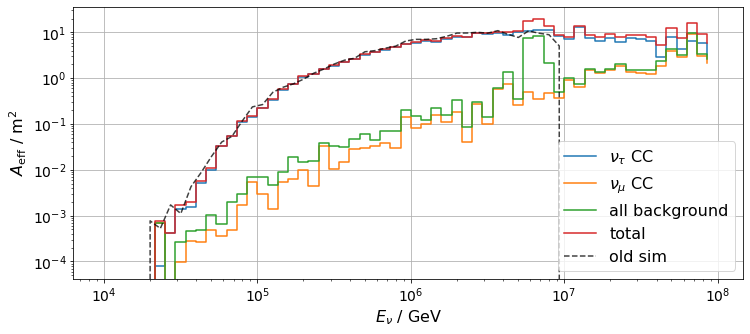

In [23]:
fig, ax = plot_eff_A()
fig.savefig('old_vs_new_effa.pdf', bbox_inches='tight', facecolor='white')
fig.savefig('old_vs_new_effa.png', bbox_inches='tight', facecolor='white')

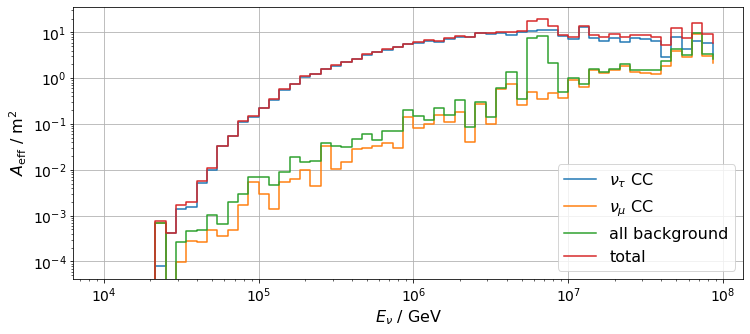

In [24]:
fig, ax = plot_eff_A(False)
fig.savefig('effa.pdf', bbox_inches='tight', facecolor='white')
fig.savefig('effa.png', bbox_inches='tight', facecolor='white')

In [25]:
# muon gun bg
apply_sig_cuts(new_df[new_df.pid == 0]).oneweight.sum() * LIVETIME

0.00527565344849683

### Count $\nu_\tau$ files passing the NET cuts in the old / new case

In [26]:
def print_total(old, new, cut):
    print(f"new: {weight_astro(new[cut]).sum()*LIVETIME:.2f}")
    print(f"old: {old[cut].weight.sum()*LIVETIME:.2f}")

In [27]:
new_tau = new_df[(new_df.it == 1) & (np.abs(new_df.pid) == 16)]
old_tau = old_df[old_df.label == 0]

In [28]:
n1_cut = lambda x: x.n1 > sig_NET1
print_total(old_tau, new_tau, n1_cut)

new: 8.61
old: 9.41


In [29]:
n2_cut = lambda x: x.n2 > sig_NET2
print_total(old_tau, new_tau, n2_cut)

new: 163.85
old: 156.07


In [30]:
n3_cut = lambda x: x.n3 > sig_NET3
print_total(old_tau, new_tau, n3_cut)

new: 48.07
old: 50.19


In [31]:
len(new_tau)

121645

In [32]:
len(old_tau)

54619

In [33]:
len(new_df[(new_df.it == 1) & (np.abs(new_df.pid) == 16)])

121645

### Look at total & signal expectation as a function of $\phi_0$, $\gamma$

In [34]:
%%time
gamma_axis = np.linspace(2, 3.4, 21)
phi_0_axis = np.linspace(2.5, 10, 21)

gamma_centers = 0.5 * (gamma_axis[1:] + gamma_axis[:-1]) 
phi_centers = 0.5 * (phi_0_axis[1:] + phi_0_axis[:-1]) / 3.0

gammas, phis = np.meshgrid(gamma_centers, phi_centers) 
sig = np.zeros_like(gammas)
bg = np.zeros_like(gammas)
snr = np.zeros_like(gammas)

# ignore muon gun here
df = apply_sig_cuts(new_df[new_df.pid != 0])
sig_mask = (df.it == 1) & (np.abs(df.pid) == 16)
bg_mask = ~sig_mask

prompt_weights = prompt_weight(df)
conv_weights = conv_weight(df)

for i, _ in enumerate(gammas):
    for j, _ in enumerate(gammas[0]):        
        gamma = gammas[i, j]
        phi  = phis[i, j]
        
        weights = weight_astro(df, phi, gamma) + prompt_weights + conv_weights
        sig_pt = (weights[sig_mask].sum() - prompt_weights[sig_mask].sum()) * LIVETIME
        bg_pt = (weights[bg_mask].sum() + prompt_weights[sig_mask].sum()) * LIVETIME
        snr_pt = sig_pt / bg_pt
        
        sig[i, j] = sig_pt
        bg[i, j] = bg_pt
        snr[i, j] = snr_pt

CPU times: user 2.1 s, sys: 429 ms, total: 2.53 s
Wall time: 1.91 s


In [35]:
total = sig + bg

Text(0, 0.5, '$\\phi_\\mathrm{astro}$')

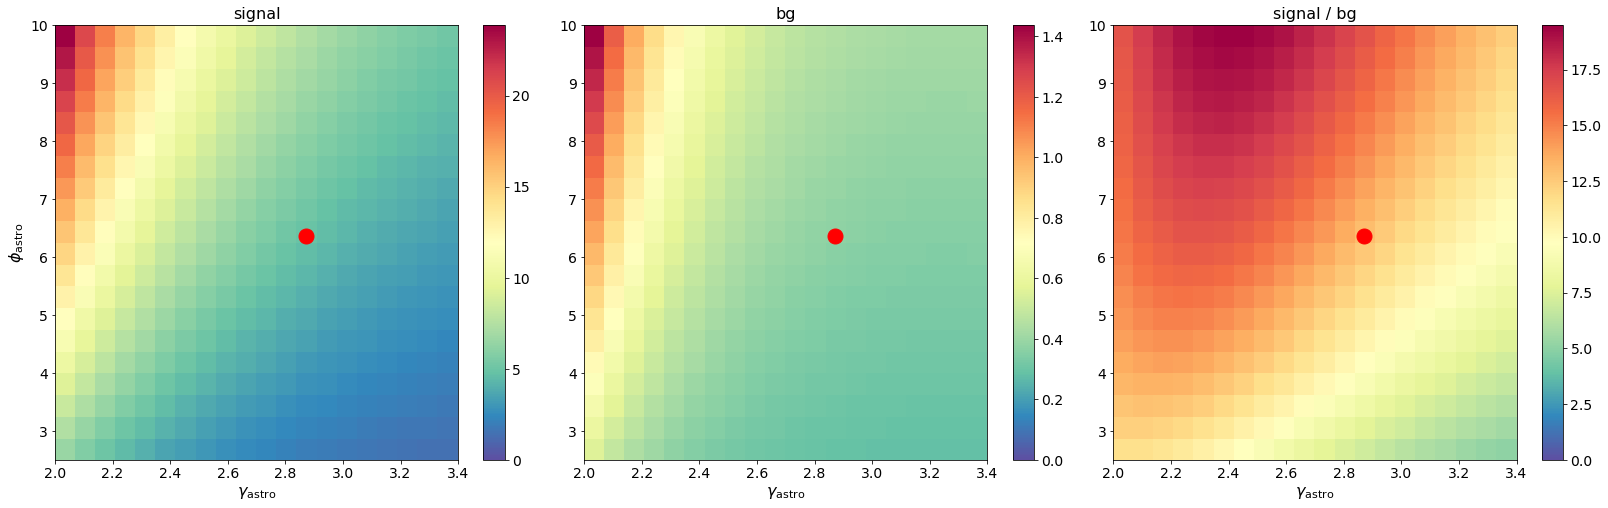

In [36]:
fig, axes = plt.subplots(figsize=(28, 8), ncols=3)
plt.subplots_adjust(wspace=0.05)

for ax, table, title in zip(axes.flat, (sig, bg, snr), ('signal', 'bg', 'signal / bg')):
    m = ax.pcolormesh(gamma_axis, phi_0_axis, table, rasterized=True, cmap='Spectral_r', vmin=0)
    ax.set_title(title)
    ax.plot([NOMINAL_GAMMA], [NOMINAL_PHI * 3.0], 'ro', markersize=15)
    plt.colorbar(m, ax=ax)
    ax.set_xlabel('$\gamma_\mathrm{astro}$')

axes[0].set_ylabel('$\phi_\mathrm{astro}$')

In [37]:
nominal_sig = 4.84
nominal_bg = 0.37
nominal_snr = nominal_sig / nominal_bg

nominals = dict(signal=nominal_sig, bg=nominal_bg, total=nominal_sig+nominal_bg)
nominals['signal / bg'] = nominal_snr

In [38]:
def fmt(v):
    return f'{v:.2f}'

def plot_contours(table, nominal, ax, title=None):
    m = ax.contour(gamma_centers, phi_centers * 3, table, cmap='cividis', vmin=0, levels=12)
    ax.clabel(m, m.levels, inline=True, fmt=fmt, fontsize=14)

    nom = ax.contour(gamma_centers, phi_centers * 3, table, levels=[nominal], 
                     colors=['k'], linestyles=['--'])
    ax.clabel(nom, nom.levels, inline=True, fmt=fmt, fontsize=14)
    
    if title is not None:
        ax.set_title(title)
    ax.plot([NOMINAL_GAMMA], [NOMINAL_PHI * 3.0], 'o', markersize=15, label='HESE')
    ax.plot([2.62], [2.04 * 3.0], 'o', markersize=15, label='Inelasticity 5yr')
    ax.plot([2.5], [6.7], 'o', markersize=15, label='GlobalFit (2015)')
    ax.plot([2.37], [1.36 * 3], 'o', markersize=15, label=r'Diffuse $\nu_\mu$')

    ax.set_xlabel('$\gamma_\mathrm{astro}$')
    ax.grid()

### Also look at Asimov LLH diff across this plane 

In [39]:
# assume best fit gives "total" as the expectation
TS = 2 * (total*(np.log(total) - np.log(bg)) + bg - total)
nominal_tot = nominal_sig + nominal_bg
TS_HESE = 2 * (nominal_tot*(np.log(nominal_tot) - np.log(nominal_bg)) + nominal_bg - nominal_tot)

### Also do the above with histogram binning

In [40]:
n_bins_net1 = 4
n_bins_net3 = 4

net1_bins = np.linspace(sig_NET1, 1.0, n_bins_net1 + 1)
net3_bins = np.linspace(sig_NET3, 1.0, n_bins_net3 + 1)

Precalculate atmos weights

In [41]:
# sensitivity dataframe
sens_df = apply_sig_cuts(new_df).copy()
sens_df['atmos_weights'] = 0
# calculate atmos_weights for neutrinos
nu_mask = sens_df.pid != 0
sens_df.loc[nu_mask, 'atmos_weights'] = weight_atmos(sens_df[nu_mask], conv_flux)
sens_df.loc[nu_mask, 'atmos_weights'] += weight_atmos(sens_df[nu_mask], prompt_flux)
# for muons, the rate is stored in the "one_weight" field
sens_df.loc[~nu_mask, 'atmos_weights'] = sens_df.loc[~nu_mask, 'oneweight']

sens_df['astro_weights'] = 0

In [42]:
sens_df[~nu_mask].atmos_weights.sum()*LIVETIME

0.00527565344849683

In [43]:
def build_sig_bg_hists(df, phi_astro, gamma_astro, n1_bins=net1_bins, n3_bins=net3_bins):
    nu_mask = df.pid != 0
    df.loc[nu_mask, 'astro_weights'] = weight_astro(df[nu_mask], phi_astro, gamma_astro)
    
    tau_cc_mask = (np.abs(df.pid) == 16) & (df.it == 1)
    tau_cc = df[tau_cc_mask]
    sig_hist = np.histogram2d(tau_cc.n1, tau_cc.n3, (n1_bins, n3_bins), 
                              weights=tau_cc.astro_weights)[0]*LIVETIME
    
    atmos_tau_cc_hist = np.histogram2d(tau_cc.n1, tau_cc.n3, (n1_bins, n3_bins), 
                                       weights=tau_cc.atmos_weights)[0]*LIVETIME
    bg = df[~tau_cc_mask]
    other_bg_hist = np.histogram2d(bg.n1, bg.n3, (n1_bins, n3_bins),
                                   weights=(bg.atmos_weights + bg.astro_weights))[0]*LIVETIME
    
    return sig_hist, atmos_tau_cc_hist + other_bg_hist

In [44]:
def plot_hist(x_bins, y_bins, hist, ax):
    """Plot a single histogram"""
    m = ax.pcolormesh(x_bins, y_bins, hist.T, rasterized=True)
    plt.colorbar(m, ax=ax)
    ax.set_xlabel("NET1")
    ax.set_ylabel("NET3")


def plot_hists(x_bins, y_bins, sig_hist, bg_hist, labels=("signal", "background")):
    """ Plot signal and background histograms"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.3)

    for ax, hist, label in zip(axes, (sig_hist, bg_hist), labels):
        plot_hist(x_bins, y_bins, hist, ax)
        ax.set_title(f'{label}: {hist.sum():.2f}')

In [45]:
nominal_sig_hist, nominal_bg_hist = build_sig_bg_hists(sens_df, NOMINAL_PHI, NOMINAL_GAMMA)

In [46]:
nominal_sig_hist.sum()

4.837046639718256

In [47]:
nominal_bg_hist.sum()

0.37656545104326755

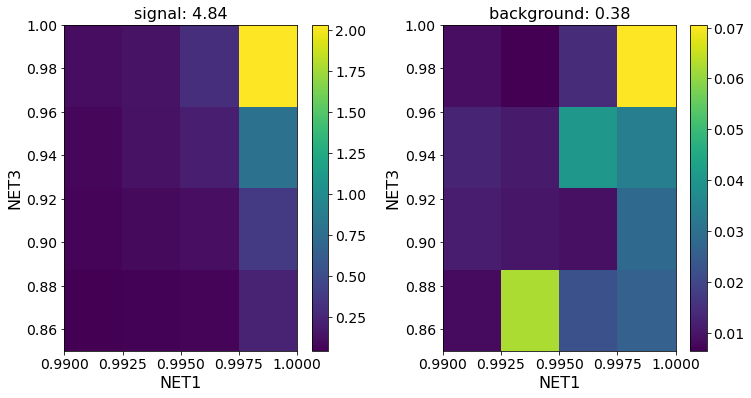

In [48]:
plot_hists(net1_bins, net3_bins, nominal_sig_hist, nominal_bg_hist)

In [49]:
def calc_binned_TS(sig_hist, bg_hist):
    tot_hist = sig_hist + bg_hist
        
    return (2 * (tot_hist*(np.log(tot_hist) - np.log(bg_hist)) + bg_hist - tot_hist)).sum()


def calc_poisson_llh(obs, sig_hist, bg_hist):
    tot_hist = sig_hist + bg_hist
    
    return (obs*np.log(tot_hist) - tot_hist).sum()

In [50]:
asimov_obs = nominal_sig_hist + nominal_bg_hist

In [51]:
%%time
binned_TS = np.zeros_like(TS)
poisson_llh = np.zeros_like(TS)
for i, _ in enumerate(gammas):
    for j, _ in enumerate(gammas[0]):
        gamma = gammas[i, j]
        phi  = phis[i, j]
        
        sig_hist, bg_hist = build_sig_bg_hists(sens_df, phi, gamma)
        binned_TS[i, j] = calc_binned_TS(sig_hist, bg_hist)
        poisson_llh[i, j] = calc_poisson_llh(asimov_obs, sig_hist, bg_hist)

CPU times: user 4.23 s, sys: 481 ms, total: 4.71 s
Wall time: 4.02 s


In [52]:
HESE_binned_TS = calc_binned_TS(nominal_sig_hist, nominal_bg_hist)
HESE_binned_TS

20.684429196554163

In [53]:
gamma_width = 0.2
phi_width = 1.67/3.0

In [54]:
prior_penalty = -(gammas - NOMINAL_GAMMA)**2/(2*gamma_width**2) - (phis - NOMINAL_PHI)**2/(2*phi_width**2)
best_llh = poisson_llh.max()
two_dllh = -2*(poisson_llh - best_llh)

HESE_llh = calc_poisson_llh(asimov_obs, nominal_sig_hist, nominal_bg_hist)
HESE_two_dllh = -2*(HESE_llh - best_llh)
HESE_two_dllh

two_dllh_with_prior = -2*(poisson_llh + prior_penalty - best_llh)

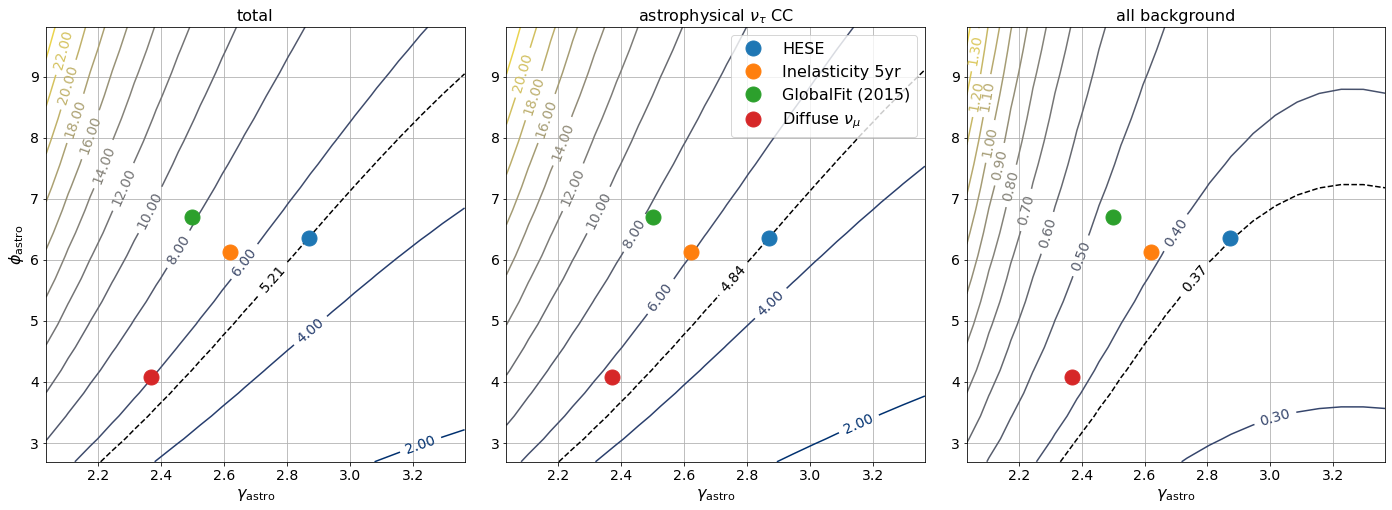

In [55]:
fig, axes = plt.subplots(figsize=(24, 8), ncols=3, nrows=1)
plt.subplots_adjust(wspace=0.1)

for ax, table, title in zip(axes.flat, (total, sig, bg), ('total', 'signal', 'bg')):
    if title == 'signal':
        label = r'astrophysical $\nu_\tau~\mathrm{CC}$'
    elif title == 'bg':
        label = 'all background'
    else:
        label = title
    
    plot_contours(table, nominals[title], ax, label)
    
    if title == 'signal':
        ax.legend()
        
axes[0].set_ylabel('$\phi_\mathrm{astro}$')
fig.savefig('counts_vs_flux_params.png', bbox_inches='tight')

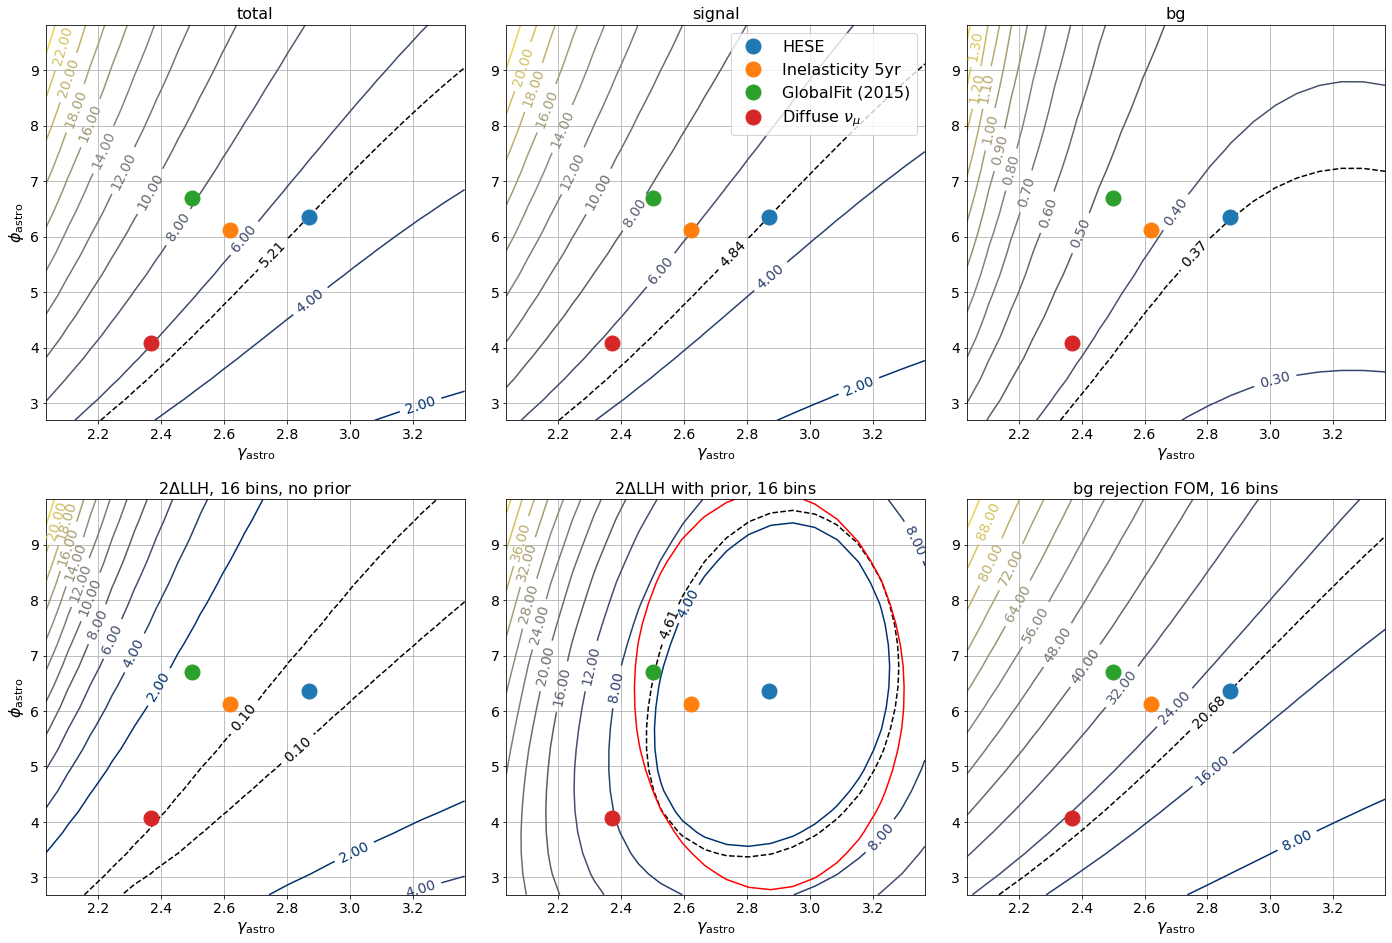

In [56]:
fig, axes = plt.subplots(figsize=(24, 16), ncols=3, nrows=2)
plt.subplots_adjust(wspace=0.1)

# for ax, table, title in zip(axes.flat, (sig, bg, snr), ('signal', 'bg', 'signal / bg')):
for ax, table, title in zip(axes.flat, (total, sig, bg), ('total', 'signal', 'bg')):
    plot_contours(table, nominals[title], ax, title)
    
    if title == 'signal':
        ax.legend()

plot_contours(two_dllh, 0.1, axes[1, 0], '2$\Delta$LLH, 16 bins, no prior')
# plot_contours(TS, TS_HESE, axes[1, 1], 'bg rejection FOM, one bin')
plot_contours(two_dllh_with_prior, 4.605, axes[1, 1], '2$\Delta$LLH with prior, 16 bins')
plot_contours(binned_TS, HESE_binned_TS, axes[1, 2], 'bg rejection FOM, 16 bins')

# plot prior in red 
axes[1, 1].contour(gamma_centers, phi_centers*3, -2*prior_penalty, levels=[4.605], colors=['red'])

for i in range(2):
    axes[i, 0].set_ylabel('$\phi_\mathrm{astro}$')
    

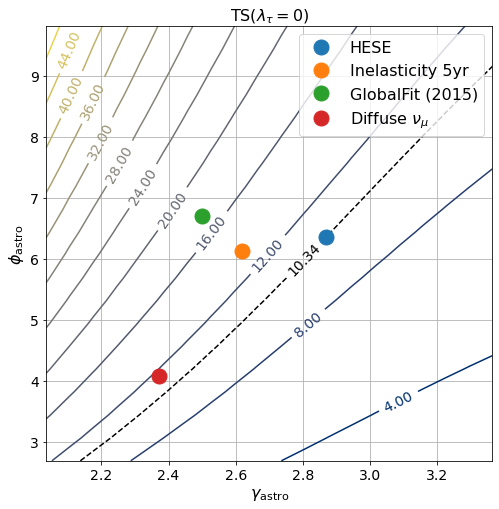

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(wspace=0.1)

plot_contours(binned_TS/2, HESE_binned_TS/2, ax, r'$\mathrm{TS}(\lambda_\tau = 0)$')

ax.set_ylabel('$\phi_\mathrm{astro}$')
ax.legend()
fig.savefig('bg_rejection_FOM.png', bbox_inches='tight')

In [58]:
from scipy import stats
norm = stats.norm()
p_val = 1 - 2*norm.cdf(-5)
chi2 = stats.chi2(1)
chi2.ppf(p_val)

25.00000000007513

In [59]:
chi2_2 = stats.chi2(2)
chi2_2.ppf(0.68)

2.27886856637673